In [1]:
from utils import convert_run, dcg_for_query, dcg_from_run, load_umbrela_scores, prettify_label
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
reranker = "mono_1000"
metric = "dcg"
retriever = "bm25"

In [ ]:
umbrela_scores = load_umbrela_scores()
reranked_all = convert_run(f'data/runs/{reranker}-{retriever}-msmarco-passage-dev-judged-1000-source.tsv.gz')
initial_retrieved = convert_run(f'data/runs/{retriever}-msmarco-passage-dev-judged-1000-source.tsv.gz')

if metric == 'dcg':
    reranked_all_metric_values = dcg_from_run(reranked_all, umbrela_scores)
    initial_retrieved_metric_values = dcg_from_run(initial_retrieved, umbrela_scores)

In [ ]:
query_ids = list(reranked_all_metric_values.keys())

In [ ]:
all_queries_rerank_depth_table_rows = [] 
all_queries_rerank_depth_max_value_table_rows = [] # query_id, max_metric_value, max_metric_value_depth
missing_pairs = set()

In [ ]:
def inspect_query(query_id):
    rerank_depth_table_rows = []
    
    query_initial_retrieved_df = initial_retrieved[initial_retrieved['query_id'] == str(query_id)]
    query_reranked_all_df = reranked_all[reranked_all['query_id'] == str(query_id)]
    query_umbrela_scores_df = umbrela_scores[umbrela_scores['query_id'] == str(query_id)]
    
    rerank_depth_table_rows.append([query_id, initial_retrieved_metric_values[str(query_id)], 0])
    max_metric_value_depth = 0
    max_metric_value = initial_retrieved_metric_values[str(query_id)]
    
    for depth in range(1, 1000):
        # Step 1: Get top depth documents from raw per query
        rows_to_rerank = query_initial_retrieved_df.sort_values(['score'], ascending=[False]).head(depth)
        # Step 2: Merge with ideal scores
        merged = pd.merge(rows_to_rerank, query_reranked_all_df, on=['query_id', 'doc_id'], how='left', suffixes=('_raw', '_ideal'))
    
        # Step 3: Sort by ideal score (descending, higher = better), then assign inverse rank
        reranked_top_d = merged.sort_values('score_ideal', ascending=False).reset_index(drop=True)
        reranked_top_d['score'] = 1 / (reranked_top_d.index + 1)
        reranked_top_d = reranked_top_d[['query_id', 'doc_id', 'score']]
    
        # Step 4: Remove original top d from raw
        raw_excluding_top_d = query_initial_retrieved_df.merge(reranked_top_d[['query_id', 'doc_id']], on=['query_id', 'doc_id'], how='outer', indicator=True)
        raw_excluding_top_d = raw_excluding_top_d[raw_excluding_top_d['_merge'] == 'left_only'].drop(columns=['_merge'])
        
        # Step 5: Combine the reranked top d back into the raw dataframe
        reranked_df = pd.concat([raw_excluding_top_d, reranked_top_d], ignore_index=True)
    
        if metric == "dcg":
            metric_value_at_depth, missing_docs = dcg_for_query(reranked_df, query_umbrela_scores_df, query_id)

            for doc_id in missing_docs:
                missing_pairs.add((query_id, doc_id))
    
            if metric_value_at_depth > max_metric_value:
                max_metric_value = metric_value_at_depth
                max_metric_value_depth = depth
    
            rerank_depth_table_rows.append([query_id, metric_value_at_depth, depth])
    
                
    rerank_depth_table_rows.append([query_id, reranked_all_metric_values[str(query_id)], 1000])
    
    if reranked_all_metric_values[str(query_id)] > max_metric_value:
        max_metric_value = reranked_all_metric_values[str(query_id)]
        max_metric_value_depth = 1000
    
    all_queries_rerank_depth_max_value_table_rows.append([query_id, max_metric_value, max_metric_value_depth])
    
    all_queries_rerank_depth_table_rows.extend(rerank_depth_table_rows)
    
    query_rerank_depth_df = pd.DataFrame(rerank_depth_table_rows, columns=['query_id', 'metric_value_at_depth', 'depth'])
    
    plt.figure(figsize=(6,4))
    
    # main line, thicker and with markers every 20 points
    plt.plot(
        query_rerank_depth_df["depth"],
        query_rerank_depth_df["metric_value_at_depth"],
        label=f"{reranker}",
        color="C0",
        linewidth=1,
    )
    
    # axis labels with clearer text
    plt.xlabel(f"Reranking Depth ({prettify_label(reranker)})", fontsize=14)
    plt.ylabel(f"{prettify_label(metric)}@10", fontsize=14)
    plt.title(f"Query # {query_id}", fontsize=14)
    plt.grid(alpha=0.3, linestyle="--")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plot/queries/{query_id}_inspect.png", dpi=300, bbox_inches="tight")
    plt.close()

In [ ]:
for query_id in query_ids:
    inspect_query(int(query_id))

In [ ]:
list(missing_pairs)

In [ ]:
all_queries_rerank_depth_df = pd.DataFrame(all_queries_rerank_depth_table_rows, columns=['query_id', 'metric_value_at_depth', 'depth'])
all_queries_rerank_depth_df.to_csv(f'data/all_queries_all_depth-{retriever}-{reranker}-{metric}.csv', index=False)

In [ ]:
all_queries_rerank_depth_max_value_df = pd.DataFrame(all_queries_rerank_depth_max_value_table_rows, columns=['query_id', 'max_metric_value', 'max_metric_value_depth'])
all_queries_rerank_depth_max_value_df.to_csv(f'data/all_queries_all_depth-max_values-{retriever}-{reranker}-{metric}.csv', index=False)

In [3]:
all_queries_rerank_depth_df = pd.read_csv(f'data/all_queries_all_depth-{retriever}-{reranker}-{metric}.csv')

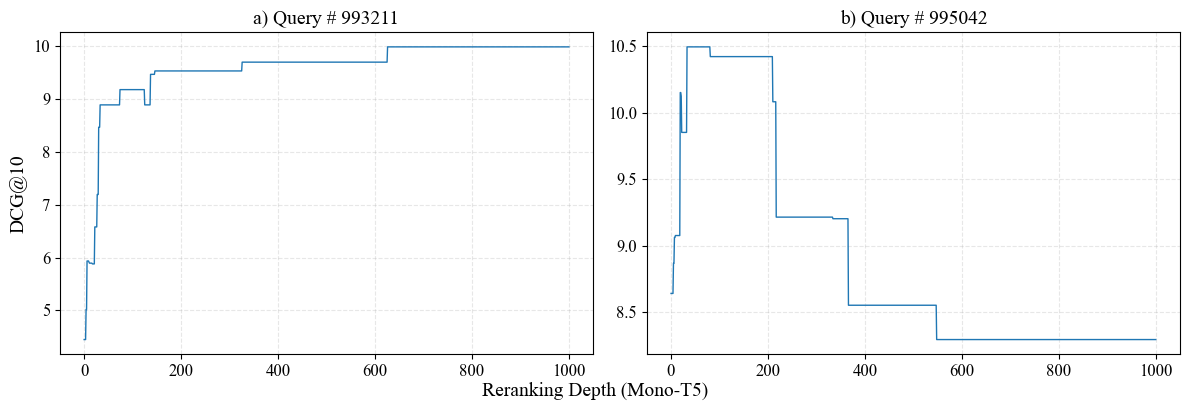

In [7]:
# Visualization
query_ids = [993211, 995042]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (ax, qid) in enumerate(zip(axes, query_ids)):
    df = all_queries_rerank_depth_df[all_queries_rerank_depth_df["query_id"] == qid]

    ax.plot(
        df["depth"],
        df["metric_value_at_depth"],
        label=f"{reranker}",
        color="C0",
        linewidth=1,
    )
    if i == 0:
        ax.set_ylabel(f"DCG@10", fontsize=14)
        ax.set_title(f"a) Query # {qid}", fontsize=14)
    else:
        ax.set_title(f"b) Query # {qid}", fontsize=14)
    ax.grid(alpha=0.3, linestyle="--")
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

fig.text(0.5, 0.01, "Reranking Depth (Mono-T5)", ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.savefig("plot/query_performance_compare.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()